In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

data_frame = pd.read_csv("SMSSpamCollection", sep="\t" ,header = None, names=["label","message"])
display(data_frame)

count = data_frame['label'].value_counts()
print(count)

ModuleNotFoundError: No module named 'matplotlib'

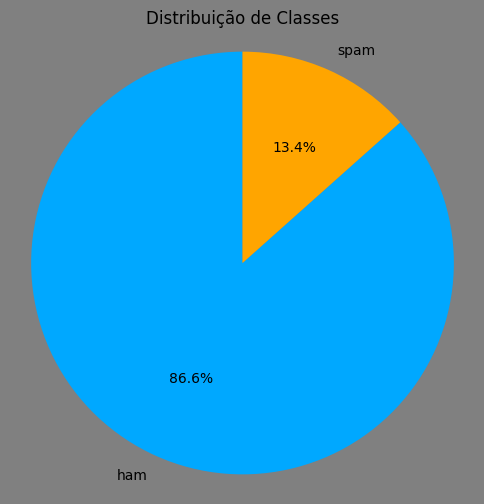

In [3]:
#plotando Distribuição de Classes
fig, ax = plt.subplots(figsize=(6,6), facecolor='grey')
colors = ['#00A8FF', '#FFA500'] 
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição de Classes')
plt.axis('equal')
plt.show()


In [4]:
#Contagem de palavras
def word_count(text):
    return len(str(text).split())
data_frame['Word_Count'] = data_frame['message'].apply(word_count)

display(data_frame)

#calculando a soma total de palavras
total_words = data_frame['Word_Count'].sum()
print("Número total de palavras: ",total_words)

,label,message,Word_Count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


Número total de palavras:  86909


In [10]:
#Realizando o pré processamento

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+','', text)

def remove_tags(text):
    return re.sub(r'#\w+|@\w+','', text)

def remove_punctuation(text):
    text = ''.join(char for char in text if char not in string.punctuation)
    return text

def remove_numbers(text):
    return re.sub(r'\d+','',text)

def remove_repetitions(text):
    return re.sub(r'(.)\1{2,}',r'\1\1', text)

def remove_small(text):
    return [word for word in text if len(word) >= 3]

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return lemmas

data_frame['message'] = data_frame['message'].astype(str).str.lower()
data_frame['message'] = data_frame['message'].apply(remove_urls)
data_frame['message'] = data_frame['message'].apply(remove_tags)
data_frame['message'] = data_frame['message'].apply(remove_punctuation)
data_frame['message'] = data_frame['message'].apply(remove_numbers)
data_frame['message'] = data_frame['message'].apply(remove_repetitions)
data_frame['message'] = data_frame['message'].apply(lambda x: x.split())
data_frame['message'] = data_frame['message'].apply(remove_stopwords)
data_frame['message'] = data_frame['message'].apply(remove_small)
data_frame['message'] = data_frame['message'].apply(lemmatize_tokens)

data_frame['Word_Count'] = data_frame['message'].apply(word_count)
display(data_frame)

total_words = data_frame['Word_Count'].sum()
print("Número total de palavras: ",total_words)



LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng/[0m

  Searched in:
    - 'C:\\Users\\maria/nltk_data'
    - 'c:\\Users\\maria\\AppData\\Local\\Programs\\Python\\Python313\\nltk_data'
    - 'c:\\Users\\maria\\AppData\\Local\\Programs\\Python\\Python313\\share\\nltk_data'
    - 'c:\\Users\\maria\\AppData\\Local\\Programs\\Python\\Python313\\lib\\nltk_data'
    - 'C:\\Users\\maria\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [10]:
documents = []
for doc in data_frame['message']:
    documents.append(doc)

vocab = set()
for doc in documents:
    vocab.update(doc)
vocab = sorted(list(vocab))

vocab_index = {}
for i in range(len(vocab)):
    vocab_index[vocab[i]] = i

def td(doc):
    td_vector = np.zeros(len(vocab))
    for word in doc:
        td_vector[vocab_index[word]] +=1
    td_vector = td_vector/len(doc)
    return td_vector

def idf(documents):
    idf = np.zeros(len(vocab))
    for doc in documents:
        seen = set()
        for word in doc:
            if word not in seen:
                idf[vocab_index[word]] += 1
                seen.add(word)
    idf = np.log(len(documents)/(idf))
    return idf

idf_vector = idf(documents)
td_table = np.array([td(doc) for doc in documents])

td_idf = td_table * idf_vector
td_idf_df = pd.DataFrame(td_idf, columns = vocab)
display(td_idf_df)



C:\Users\maria\AppData\Local\Temp\ipykernel_10792\2190733501.py:18: RuntimeWarning: invalid value encountered in divide
  td_vector = td_vector/len(doc)


,aah,aaniye,aaooright,aathilove,aathiwhere,abbey,abdomen,abeg,abelu,aberdeen,...,£msg,£perweeksub,£perwksub,£pm,£pmmorefrommobilebremovedmobypoboxlsyf,£week,£wk,üll,“harry,…thanks
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
